<a href="https://colab.research.google.com/github/camila-cg/analise-dados-educacionais/blob/main/Teste_an%C3%A1lise_base_educacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, metrics, tree
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plot
# from sklearn import preprocessing


Fixando semente para reprodutibilidade dos resultados

In [2]:
np.random.seed(42)

Leitura dos dados

In [3]:
dataset_mat = pd.read_csv("https://raw.githubusercontent.com/camila-cg/analise-dados-educacionais/main/student-mat.csv", sep = ';')
dataset_port = pd.read_csv("https://raw.githubusercontent.com/camila-cg/analise-dados-educacionais/main/student-por.csv", sep = ';')

dataset_mat.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6


## Pré-Processamento

###Verificação de dados faltantes

Verificando a presença de dados faltantes na base de dados

In [4]:
print(dataset_mat.info())
print(dataset_port.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

Verificamos que as bases a serem utilizadas não possuem valores faltantes.

### Transformação dos Dados

Os atributos que assumem apenas dois valores possíveis, como os valores **'yes'** e **'no'** serão transformados em valores binários, dado que os modelos de aprendizado de máquina não conseguem trabalhar com strings, apenas números

In [5]:
def labelEncoder(df, colunas, filename):
  label_df = df.copy()
  le = LabelEncoder()
  
  for col in colunas:
    label_df[col] = le.fit_transform(label_df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    # print(col)
    # print(le_name_mapping)
    arq = open(filename, 'a')
    print("Coluna: ", col, file=arq)
    print(le_name_mapping, file=arq)
    print('\n', file=arq)
    arq.close()
  return label_df

colunas_bin = ["school", "sex", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "address", "famsize", "Pstatus"]

dataset_mat_proc = labelEncoder(dataset_mat, colunas_bin, 'label_encoder.txt')
dataset_port_proc = labelEncoder(dataset_port, colunas_bin, 'label_encoder.txt')

print("Primeira linha do dataset de matemática após a conversão dos atributos binários:")
dataset_mat_proc.head(1)

Primeira linha do dataset de matemática após a conversão dos atributos binários:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6


Agora vamos converter os atributos categóricos que assumem mais do que dois valores possíveis em valores discretos.

In [6]:
colunas_cat = ["Mjob", "Fjob", "reason", "guardian"]

dataset_mat_proc = labelEncoder(dataset_mat_proc, colunas_cat, 'label_cat.txt')
dataset_port_proc = labelEncoder(dataset_port_proc, colunas_cat, 'label_cat.txt')

print("Primeira linha do dataset de matemática após a conversão dos atributos categóricos:")
dataset_mat_proc.head(1)

Primeira linha do dataset de matemática após a conversão dos atributos categóricos:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6


###Adicionando colunas de classe

Será criada uma **classe binária** que indicará se o aluno foi aprovado na disciplina ou não, onde os modelos de classificação deverão prever com base nas informações disponíveis sobre cada aluno se ele será ou não aprovado.

In [7]:
dataset_mat_proc_final = dataset_mat_proc.copy()
dataset_mat_proc_final['aprovado'] = ''
dataset_mat_proc_final.loc[(dataset_mat_proc_final.G3 >= 10), 'aprovado'] = 1
dataset_mat_proc_final.loc[(dataset_mat_proc_final.G3 < 10), 'aprovado'] = 0
dataset_mat_proc_final.drop('G3', axis=1, inplace=True)

dataset_port_proc_final = dataset_port_proc.copy()
dataset_port_proc_final['aprovado'] = ''
dataset_port_proc_final.loc[(dataset_port_proc_final.G3 >= 10), 'aprovado'] = 1
dataset_port_proc_final.loc[(dataset_port_proc_final.G3 < 10), 'aprovado'] = 0
dataset_port_proc_final.drop('G3', axis=1, inplace=True)
dataset_port_proc_final.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,aprovado
0,0,0,18,1,0,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,1
1,0,0,17,1,0,1,1,1,0,2,0,0,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,1


Será criada também uma coluna que indicará o conceito final do aluno, seguindo a seguinte regra:
- Notas entre [16, 20]: conceito **A**,
- Notas entre [14, 16): conceito **B**,
- Notas entre [12, 14): conceito **C**,
- Notas entre [10, 12): conceito **D** e
- Notas entre [0, 10): conceito **F**

In [9]:
dataset_mat_proc_conceito = dataset_mat_proc.copy()
dataset_mat_proc_conceito['conceito'] = ''
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 0) & (dataset_mat_proc_conceito.G3 < 10), 'conceito'] = 'F'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 10) & (dataset_mat_proc_conceito.G3 < 12), 'conceito'] = 'D'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 12) & (dataset_mat_proc_conceito.G3 < 14), 'conceito'] = 'C'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 14) & (dataset_mat_proc_conceito.G3 < 16), 'conceito'] = 'B'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 16) & (dataset_mat_proc_conceito.G3 <= 20), 'conceito'] = 'A'
dataset_mat_proc_conceito.drop('G3', axis=1, inplace=True)

dataset_port_proc_conceito = dataset_port_proc.copy()
dataset_port_proc_conceito['conceito'] = ''
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 0) & (dataset_port_proc_conceito.G3 < 10), 'conceito'] = 'F'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 10) & (dataset_port_proc_conceito.G3 < 12), 'conceito'] = 'D'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 12) & (dataset_port_proc_conceito.G3 < 14), 'conceito'] = 'C'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 14) & (dataset_port_proc_conceito.G3 < 16), 'conceito'] = 'B'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 16) & (dataset_port_proc_conceito.G3 <= 20), 'conceito'] = 'A'
dataset_port_proc_conceito.drop('G3', axis=1, inplace=True)
dataset_port_proc_conceito.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,conceito
0,0,0,18,1,0,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,D
1,0,0,17,1,0,1,1,1,0,2,0,0,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,D
2,0,0,15,1,1,1,1,1,0,2,2,1,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,C


Por fim, é necessário converter os conceitos criados em valores discretos também.

In [10]:
dataset_mat_proc_conceito = labelEncoder(dataset_mat_proc_conceito, ['conceito'], 'label_cat_conceito.txt')
dataset_port_proc_conceito = labelEncoder(dataset_port_proc_conceito, ['conceito'], 'label_cat_conceito.txt')

##Correlação dos atributos

As bases possuem muitos atributos e talvez nem todos sejam relevantes para a classificação da situação dos alunos em cada disciplina. Para isso é necessária a análise da matriz de correlação.

In [12]:
def plotCorrelationHeatMap(dataFrame, chartTitle):
  correlation = dataFrame.corr(method='pearson') #pearson, kendall, spearman
  plot.figure(figsize=(26, 26))
  # sns.heatmap(correlation, cmap="Greens", annot=True)
  sns.heatmap(correlation, annot=True, fmt=".2f", linewidths=.6)
  plot.title(chartTitle)
  plot.show()


Analisando a correlação com os datasets contendo a nota final (G3):

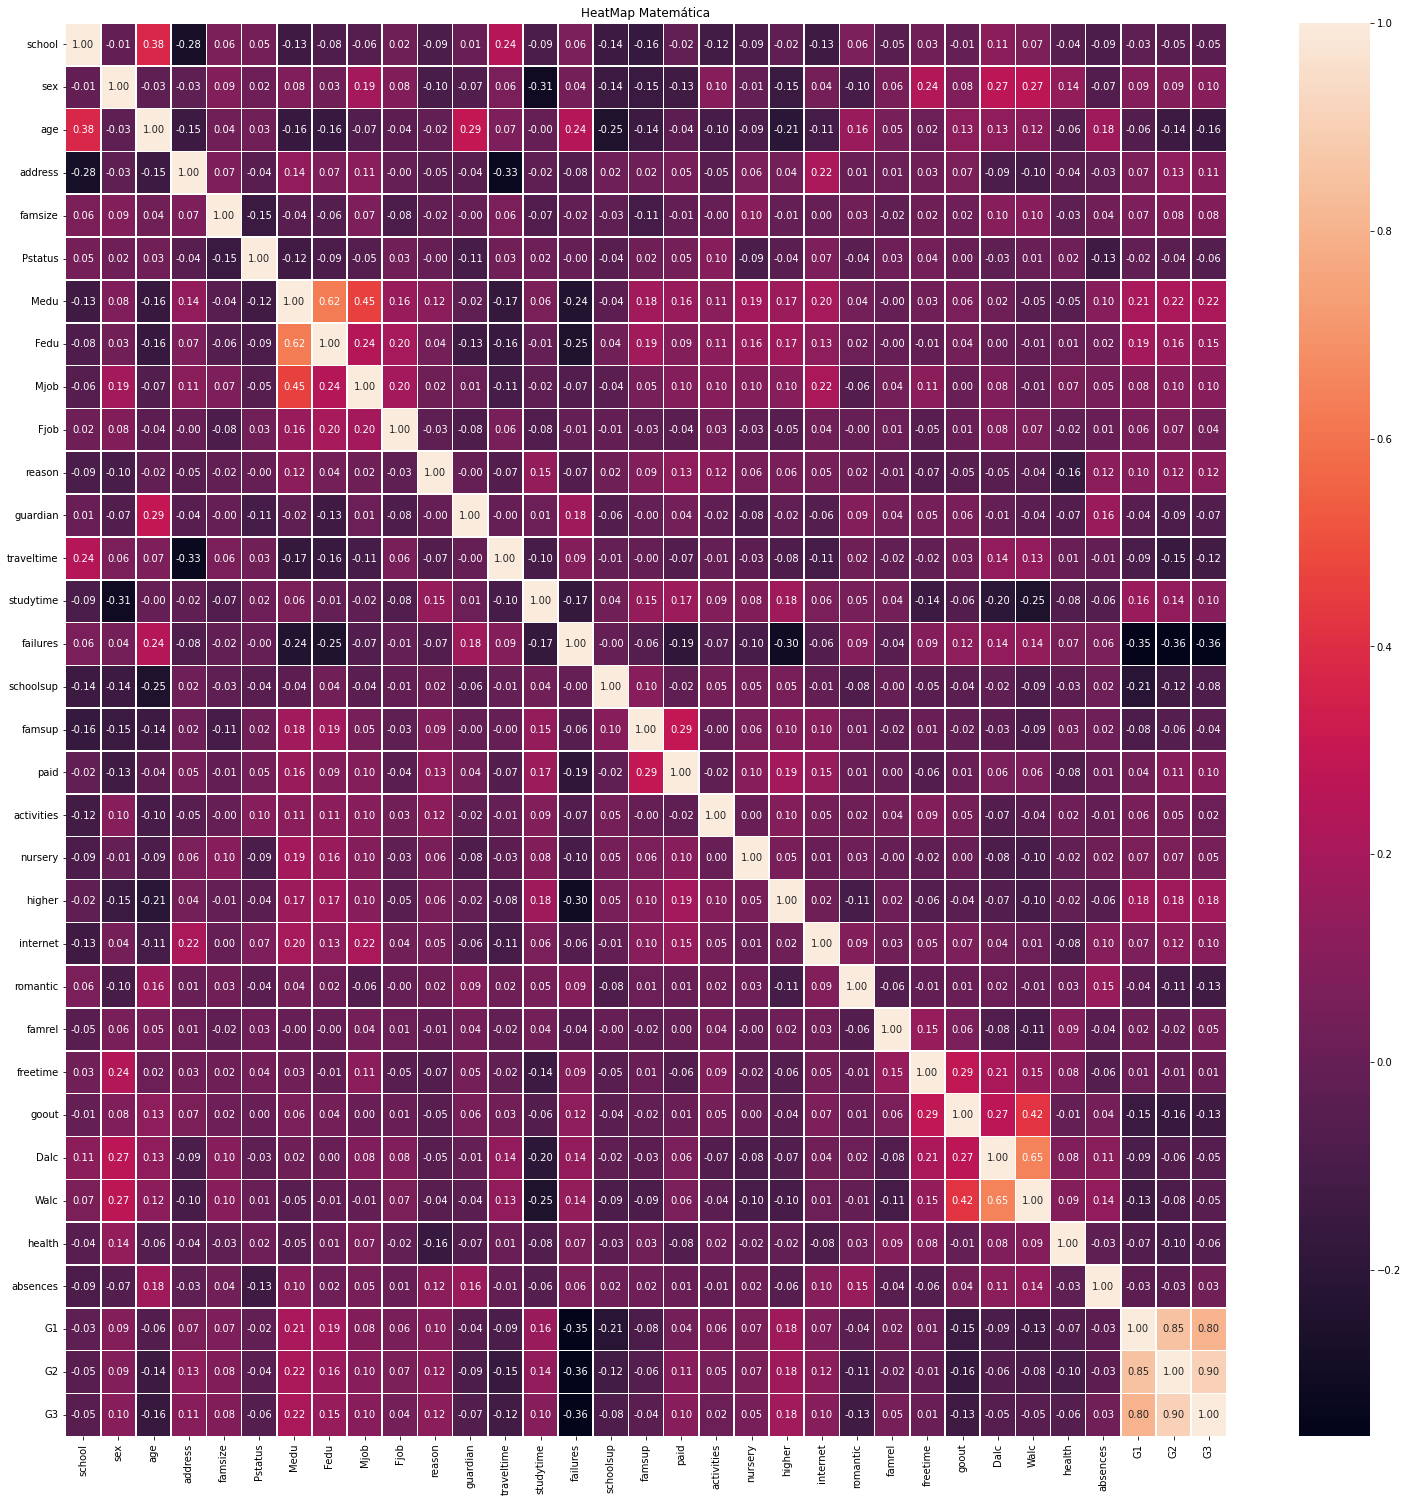

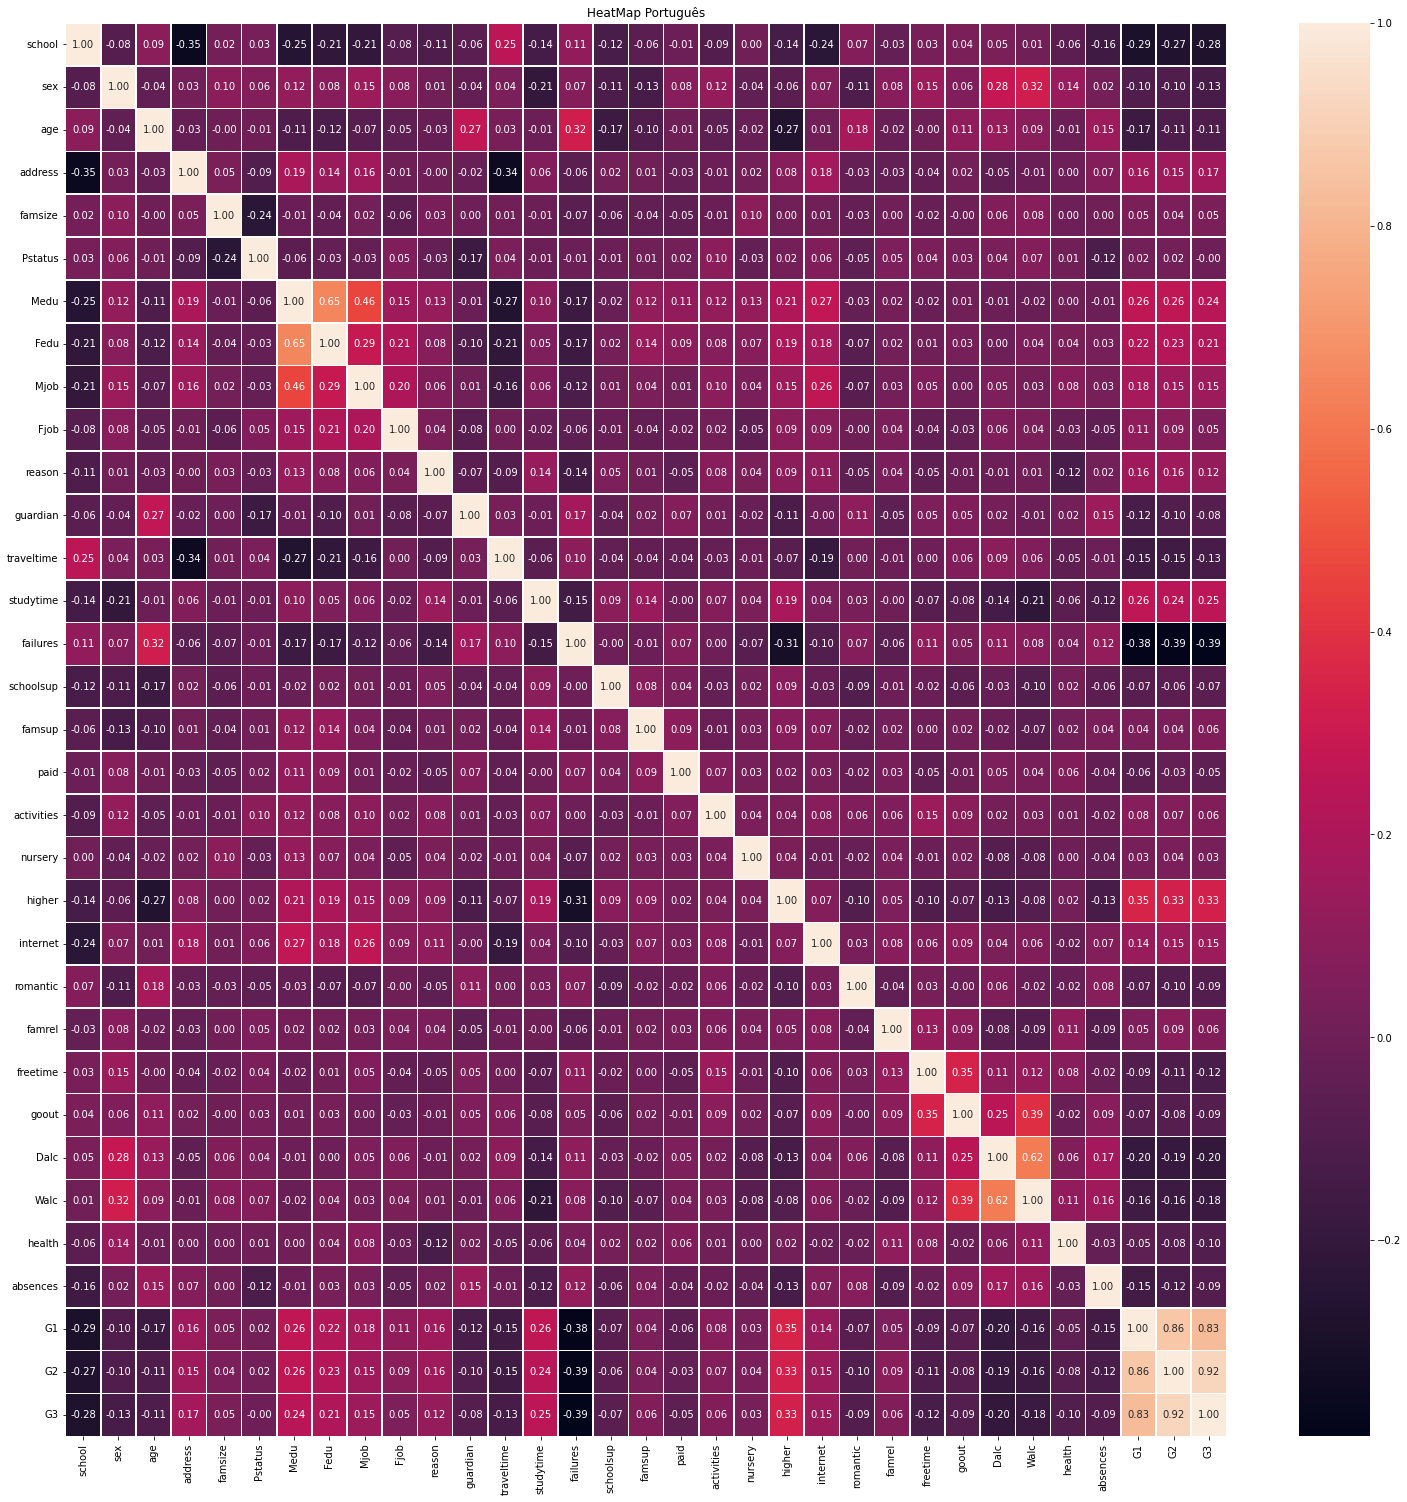

In [13]:
plotCorrelationHeatMap(dataset_mat_proc, 'HeatMap Matemática')
plotCorrelationHeatMap(dataset_port_proc, 'HeatMap Português')

Analisando a correlação com os datasets contendo a situação final do aluno (aprovado ou reprovado):

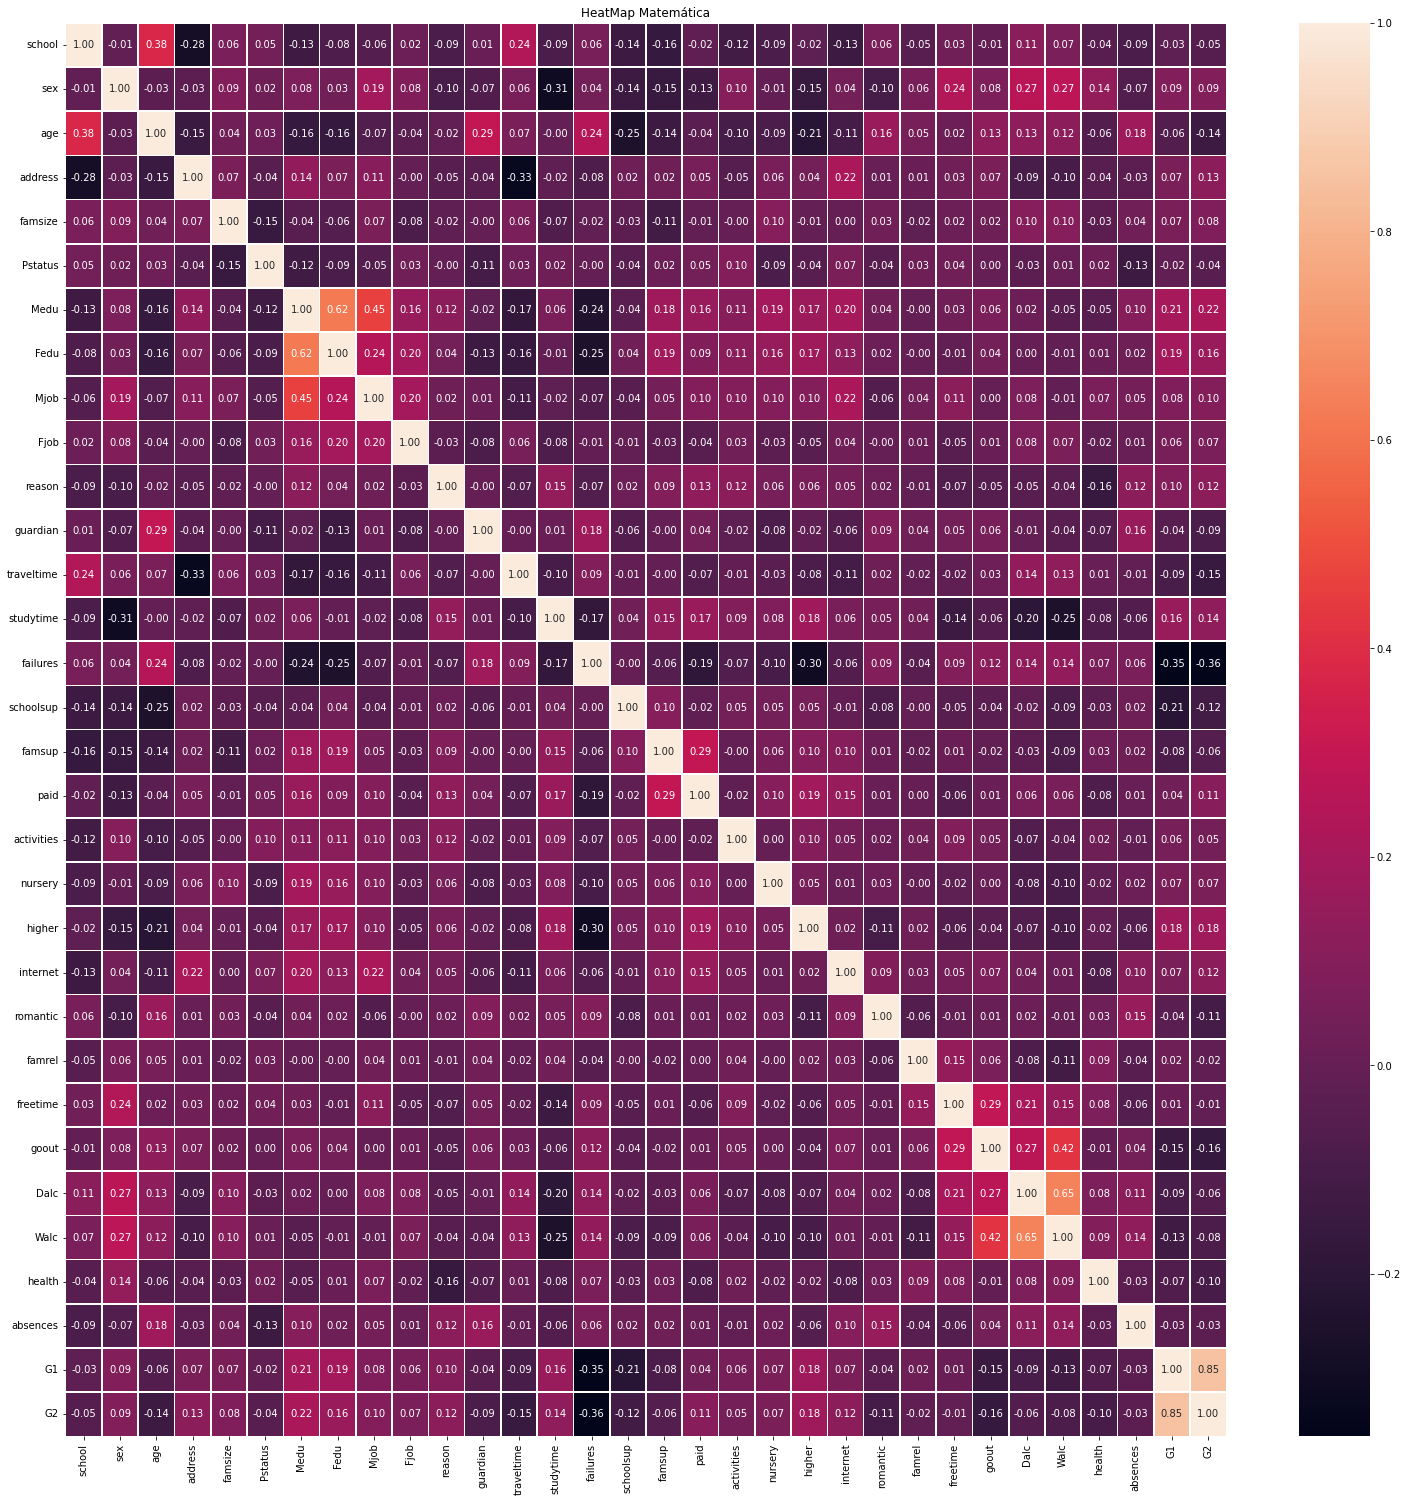

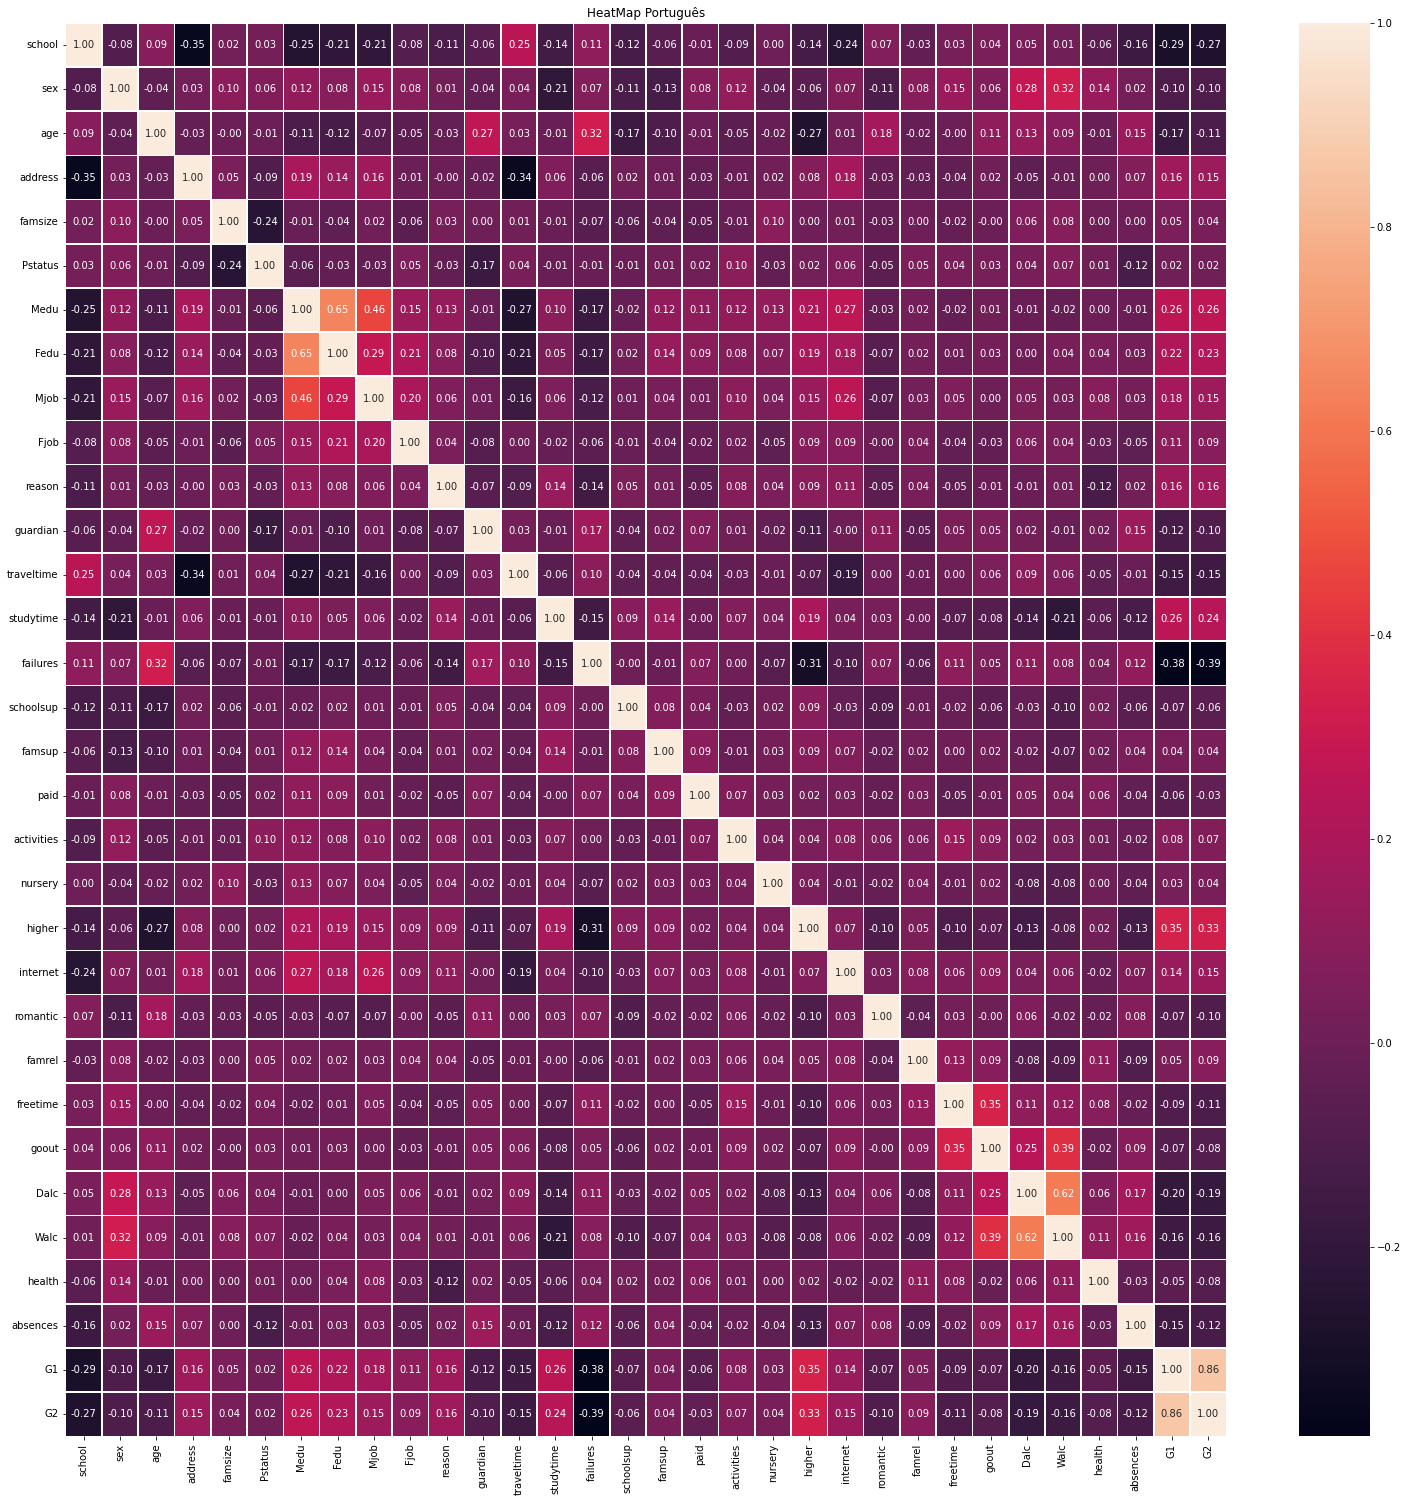

In [14]:
plotCorrelationHeatMap(dataset_mat_proc_final, 'HeatMap Matemática')
plotCorrelationHeatMap(dataset_port_proc_final, 'HeatMap Português')

Analisando a correlação com os datasets contendo o conceito final do aluno (A, B, C, D, F):

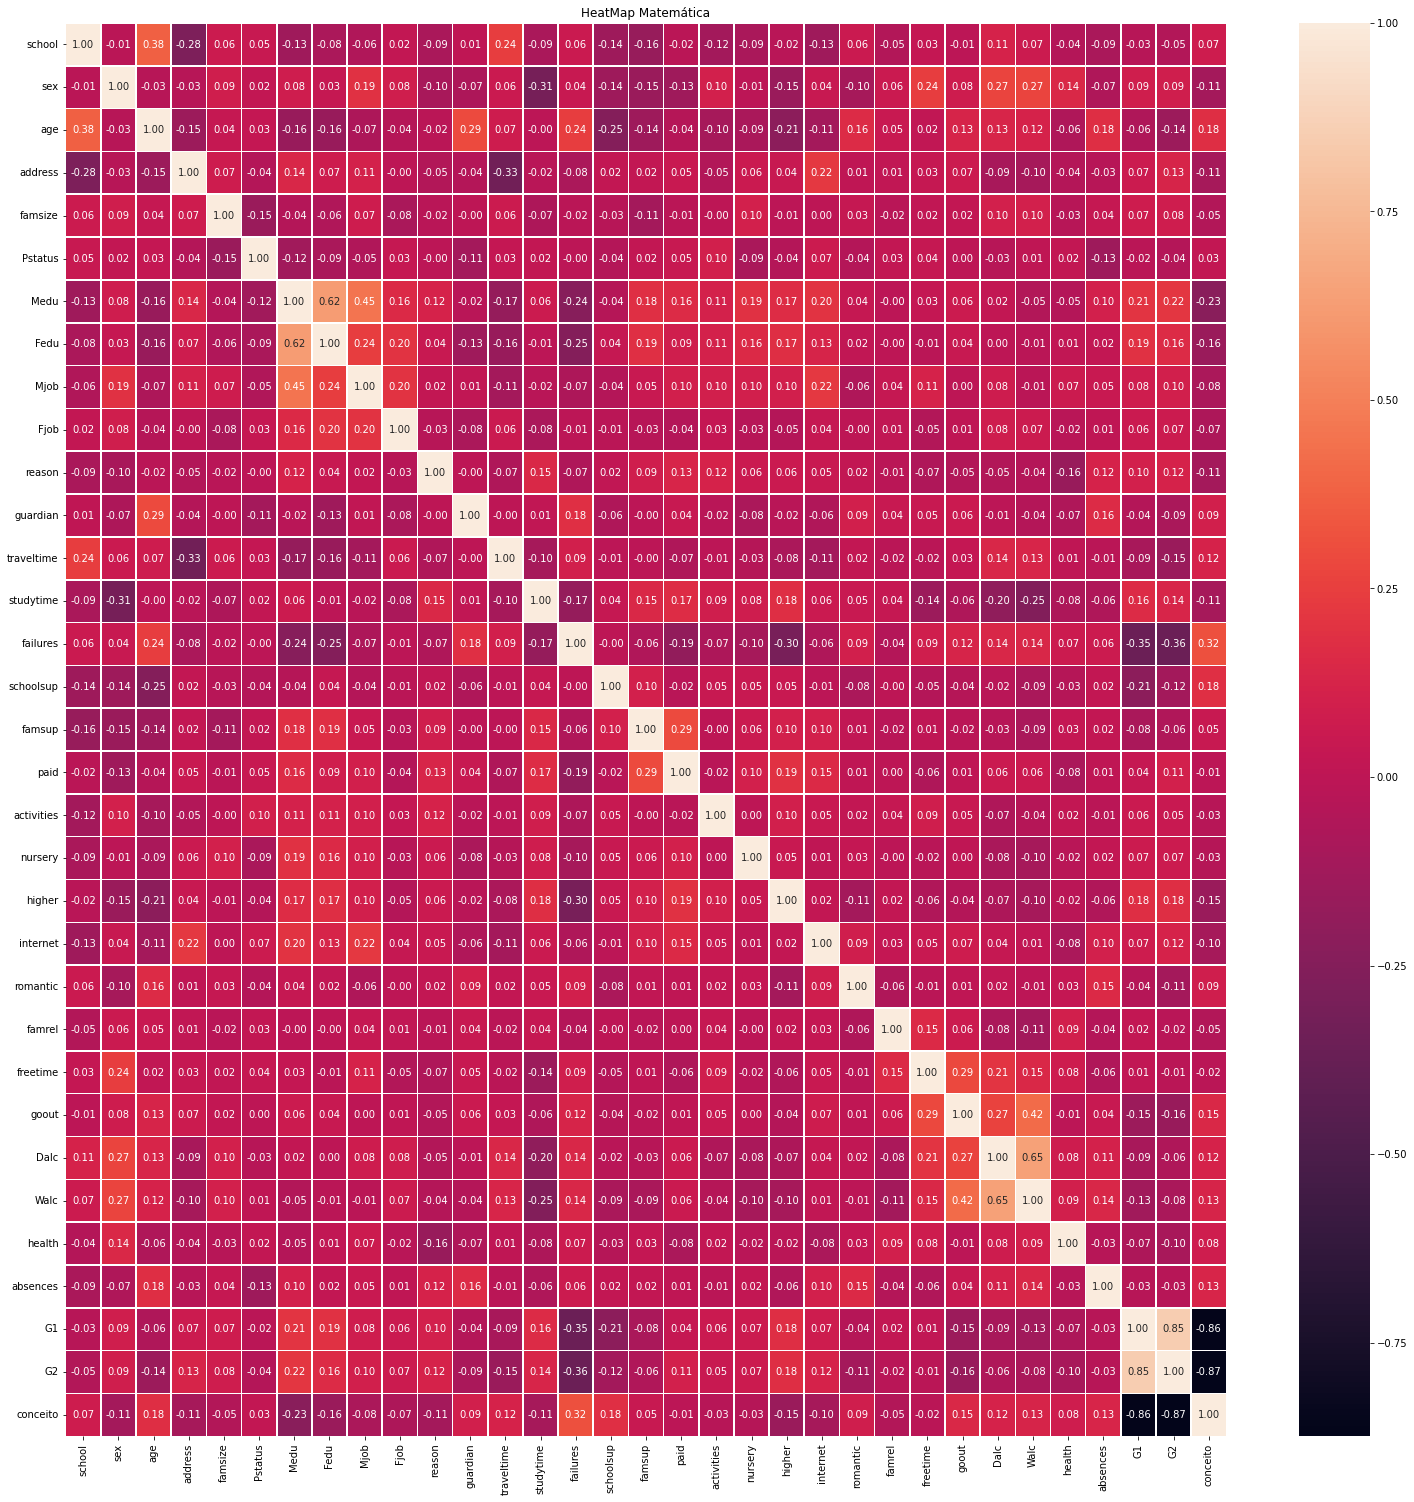

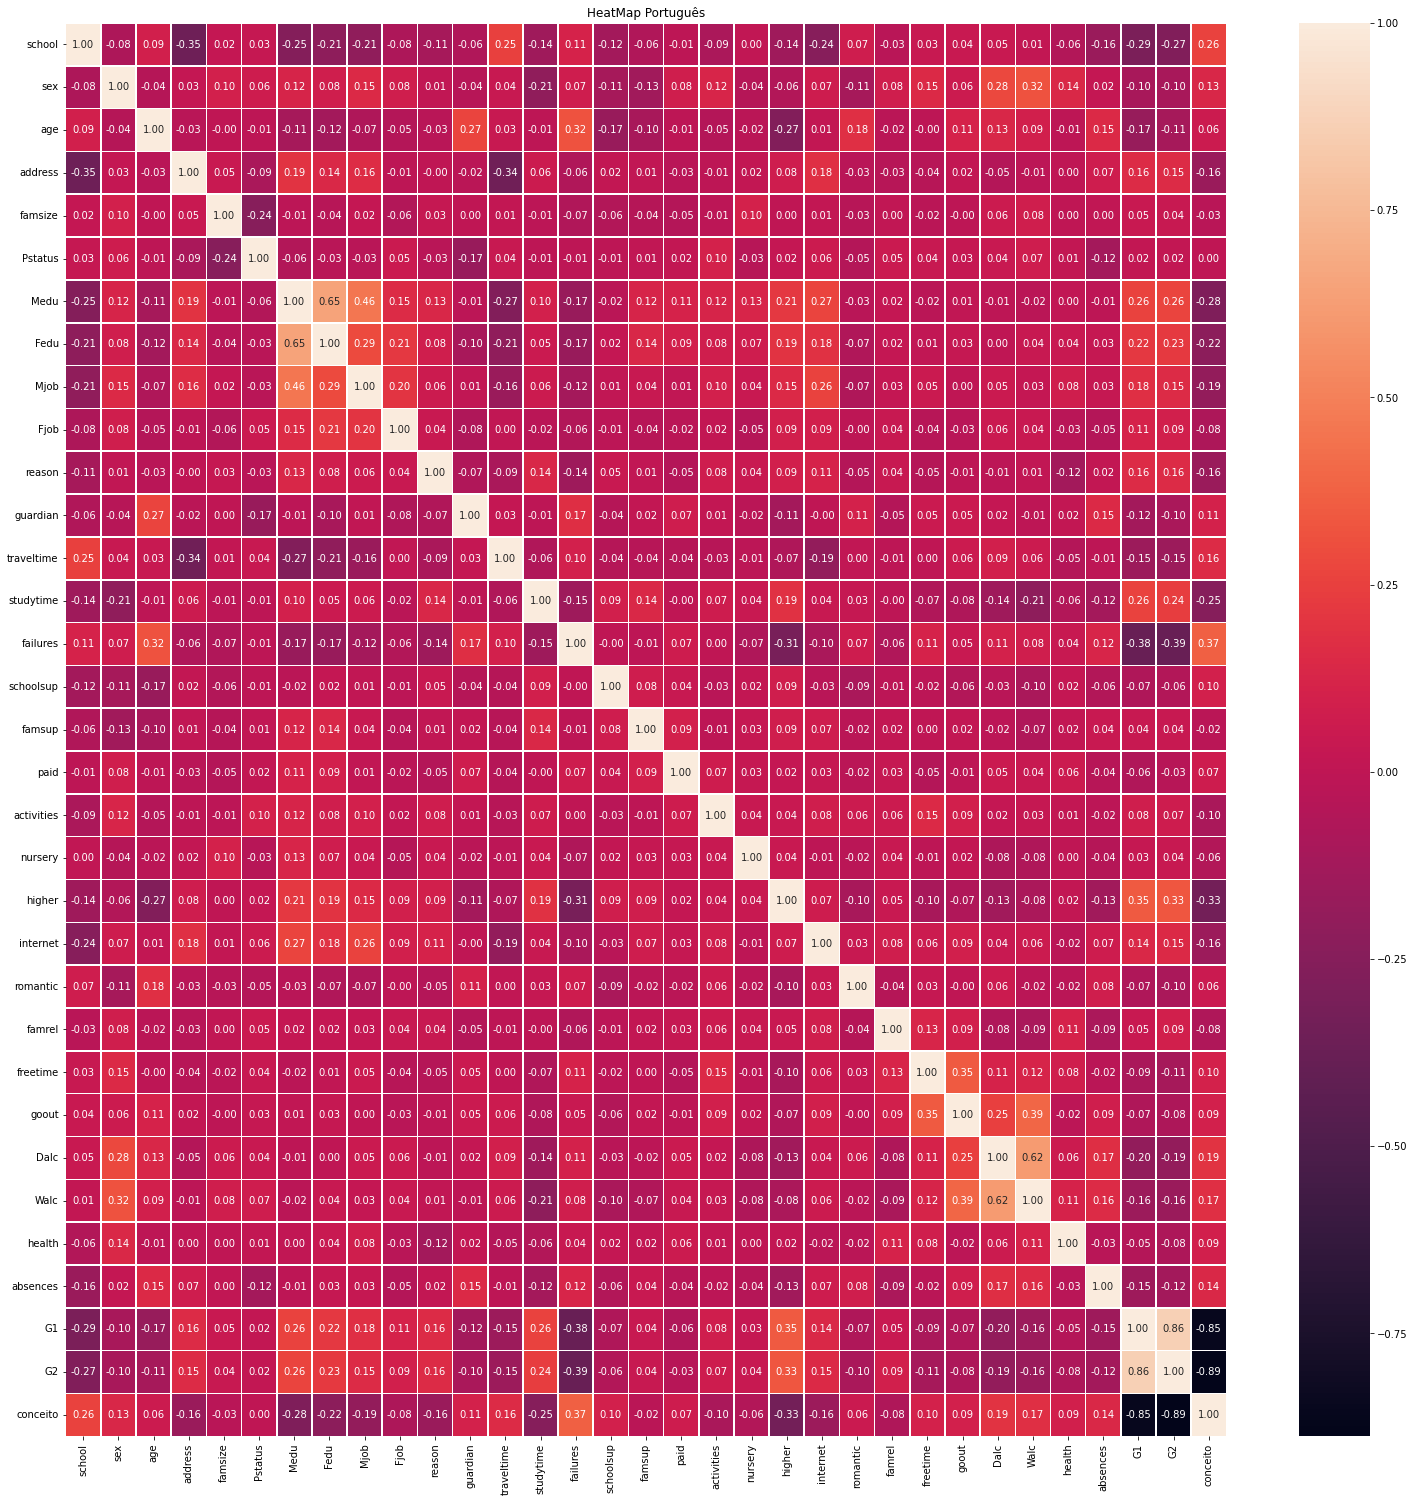

In [15]:
plotCorrelationHeatMap(dataset_mat_proc_conceito, 'HeatMap Matemática')
plotCorrelationHeatMap(dataset_port_proc_conceito, 'HeatMap Português')

##Divisão da base

Divisão da base em treino e teste, sendo 70% para treino e 30% para teste.

In [ ]:
def dividirBase(df, atributo_classe):
  X = df.drop(atributo_classe, axis=1)
  Y = df[atributo_classe]

  xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.30)
  return (xTrain, xTest, yTrain, yTest)


In [ ]:
# treino_mat, validacao_mat, teste_mat = np.split(dataset_mat.sample(frac=1), [int(.6*len(dataset_mat)), int(.8*len(dataset_mat))])
# treino_port, validacao_port, teste_port = np.split(dataset_port.sample(frac=1), [int(.6*len(dataset_port)), int(.8*len(dataset_port))])

# 'G3', 'conceito'
# attributeToPredict = 'G3'
# X_mat = dataset_mat_proc.drop(attributeToPredict)
# Y_mat = dataset_mat_proc[attributeToPredict]

xTrain_mat, xTest_mat, yTrain_mat, yTest_mat = dividirBase(dataset_mat_proc, 'G3')
xTrain_port, xTest_port, yTrain_port, yTest_port = dividirBase(dataset_port_proc, 'G3')

# Modelos de classificação

In [ ]:
def computeMetrics(test, prediction, bestEstimator = None):

  metricsDataFrame = {}
  metricsDataFrame['accuracy'] = metrics.accuracy_score(test, prediction)

  metricsDataFrame['precisionMicro'] = metrics.precision_score(test, prediction, average='micro')
  metricsDataFrame['precisionMacro'] = metrics.precision_score(test, prediction, average='macro')
  metricsDataFrame['precisionWeighted'] = metrics.precision_score(test, prediction, average='weighted')

  metricsDataFrame['recallMicro'] = metrics.recall_score(test, prediction, average='micro')
  metricsDataFrame['recallMacro'] = metrics.recall_score(test, prediction, average='macro')
  metricsDataFrame['recallWeighted'] = metrics.recall_score(test, prediction, average='weighted')

  metricsDataFrame['f1Micro'] = metrics.f1_score(test, prediction, average='micro')
  metricsDataFrame['f1Macro'] = metrics.f1_score(test, prediction, average='macro')
  metricsDataFrame['f1Weighted'] = metrics.f1_score(test, prediction, average='weighted')

  if(bestEstimator != None):
      metricsDataFrame['bestEstimator'] = bestEstimator

  return pd.DataFrame(data=metricsDataFrame, index=[0])

In [ ]:
def decisionTree(dataset):
    print("Decision Tree")
    model = tree.DecisionTreeClassifier()
    gridSearchParameters = {
        "criterion": ["gini", "entropy"],
        "min_samples_split": [5, 7, 9, 10, 20],
        "max_depth": [6, 7, 8],
        "min_samples_leaf": [4, 5, 6, 8, 10],
        "max_leaf_nodes": [5, 10, 20],
        "max_features": [8, 9, 10, 11, 12, 13, 14]
    }
    
    cv = StratifiedKFold(n_splits=10)
    model = GridSearchCV(model, gridSearchParameters, cv=cv, scoring='accuracy', refit=True, verbose=1, n_jobs=-1) #CV default

    model.fit(dataset['xTrain'], dataset['yTrain'])

    prediction = model.predict(dataset['xTest'])

    metricsDataFrame = computeMetrics(dataset['yTest'], prediction, model.best_estimator_)  

    return metricsDataFrame

In [ ]:
def classificadores(df, atributoAlvo):
  classifiersFunctions = [
                        # {'name': 'KNN', 'function': knnGridSearch},
                        # {'name': 'Naive Bayes', 'function': naiveBayes}, 
                        {'name': 'Decision Tree', 'function': decisionTree}
                        # ,
                        # {'name': 'SVM', 'function': SVM},
                        # {'name': 'MLP', 'function': MLP}
                        ]
  dfCopy = df.copy()
  xTrain, xTest, yTrain, yTest = dividirBase(dfCopy, atributoAlvo)
  # xTrain = pd.get_dummies(xTrain)
  # xTest = pd.get_dummies(xTest)
  # print(xTrain.columns)

  classifiersDataset = {'xTrain': xTrain, 'xTest': xTest, 'yTrain': yTrain, 'yTest': yTest }
  metricsDataFrame = {}

  for classifier in classifiersFunctions:
    metrics = classifier['function'](classifiersDataset)
    if(type(metrics) == dict):
        for key in metrics:
            metricsDataFrame[key] = metrics[key]
    else:
        metricsDataFrame[classifier['name']] = metrics

  return metricsDataFrame



In [ ]:
# dataset_mat_proc_conceito = dataset_mat_proc.drop(['G3', 'aprovado'], axis=1)
# resultados = classificadores(dataset_mat_proc_conceito, 'conceito')
# resultados

In [ ]:
resultados

#Previsão da nota final do aluno